# 부스트캠프 AI Tech 8기 
# 도메인공통프로젝트 Wrap-up Report
* **한국어 영화 리뷰 감성 분류 모델 개발**
* **작성자:** 조주익 T8196

---

## 1. 프로젝트 개요
### 프로젝트 목표 및 배경
* 한국어 영화리뷰를 기반으로 한 다중 감성 분류 모델 개발을 목표로 함
* 감성분류의 결과는 고객만족도 분석, 콘텐츠 추천, 여론 분석 등 다양한 산업 현장에서 활용됨
* 목표를 이루는 과정에서 텍스트로 구성된 비정형데이터의 전처리, 정규화, 토큰화, 임베딩 기법, 분류모델의 설계/학습, 평가지표에 따른 성능 최적화 등의 기술적 과제들을 해결함
### 개발 환경
* 서버(upstage 제공): Ubuntu 20.04(8 CPU, 88G RAM, 50G), GPU(V100, 32GB VRAM)
* 개발 도구: Visual Code, git, tmux, hugging face transformers, wandb
* 협업 도구: zoom, slack
### 프로젝트 구조
* 본 프로젝트는 1인 프로젝트로, 한 명이 여러 역할을 수행함
    * 문제 분석, 목표 설정, 작업 및 일정 계획 수립
    * 개발환경 셋팅, base line 코드 구현
    * EDA, feature engineering, 모델 선정 혹은 개발, 학습 및 파라미터 튜닝
    * 추론 수행, 결과 제출, 결과 분석
### 사용 데이터셋의 구조
* 학습 데이터(train.csv)
    * 컬럼: ID(int64), review(object), label(int64), type(object)
    * Label: 0-강한부정(40.78), 1-약한부정(9.73), 2-약한긍정(35.55), 3-강한긍정(13.93)
    * Type: augment(50%), original(50%)
* 평가 데이터(test.csv)
    * 컬럼: ID(int64), review(object)
    


## 2. 프로젝트 수행 절차 및 방법
* 프로젝트 수행 절차


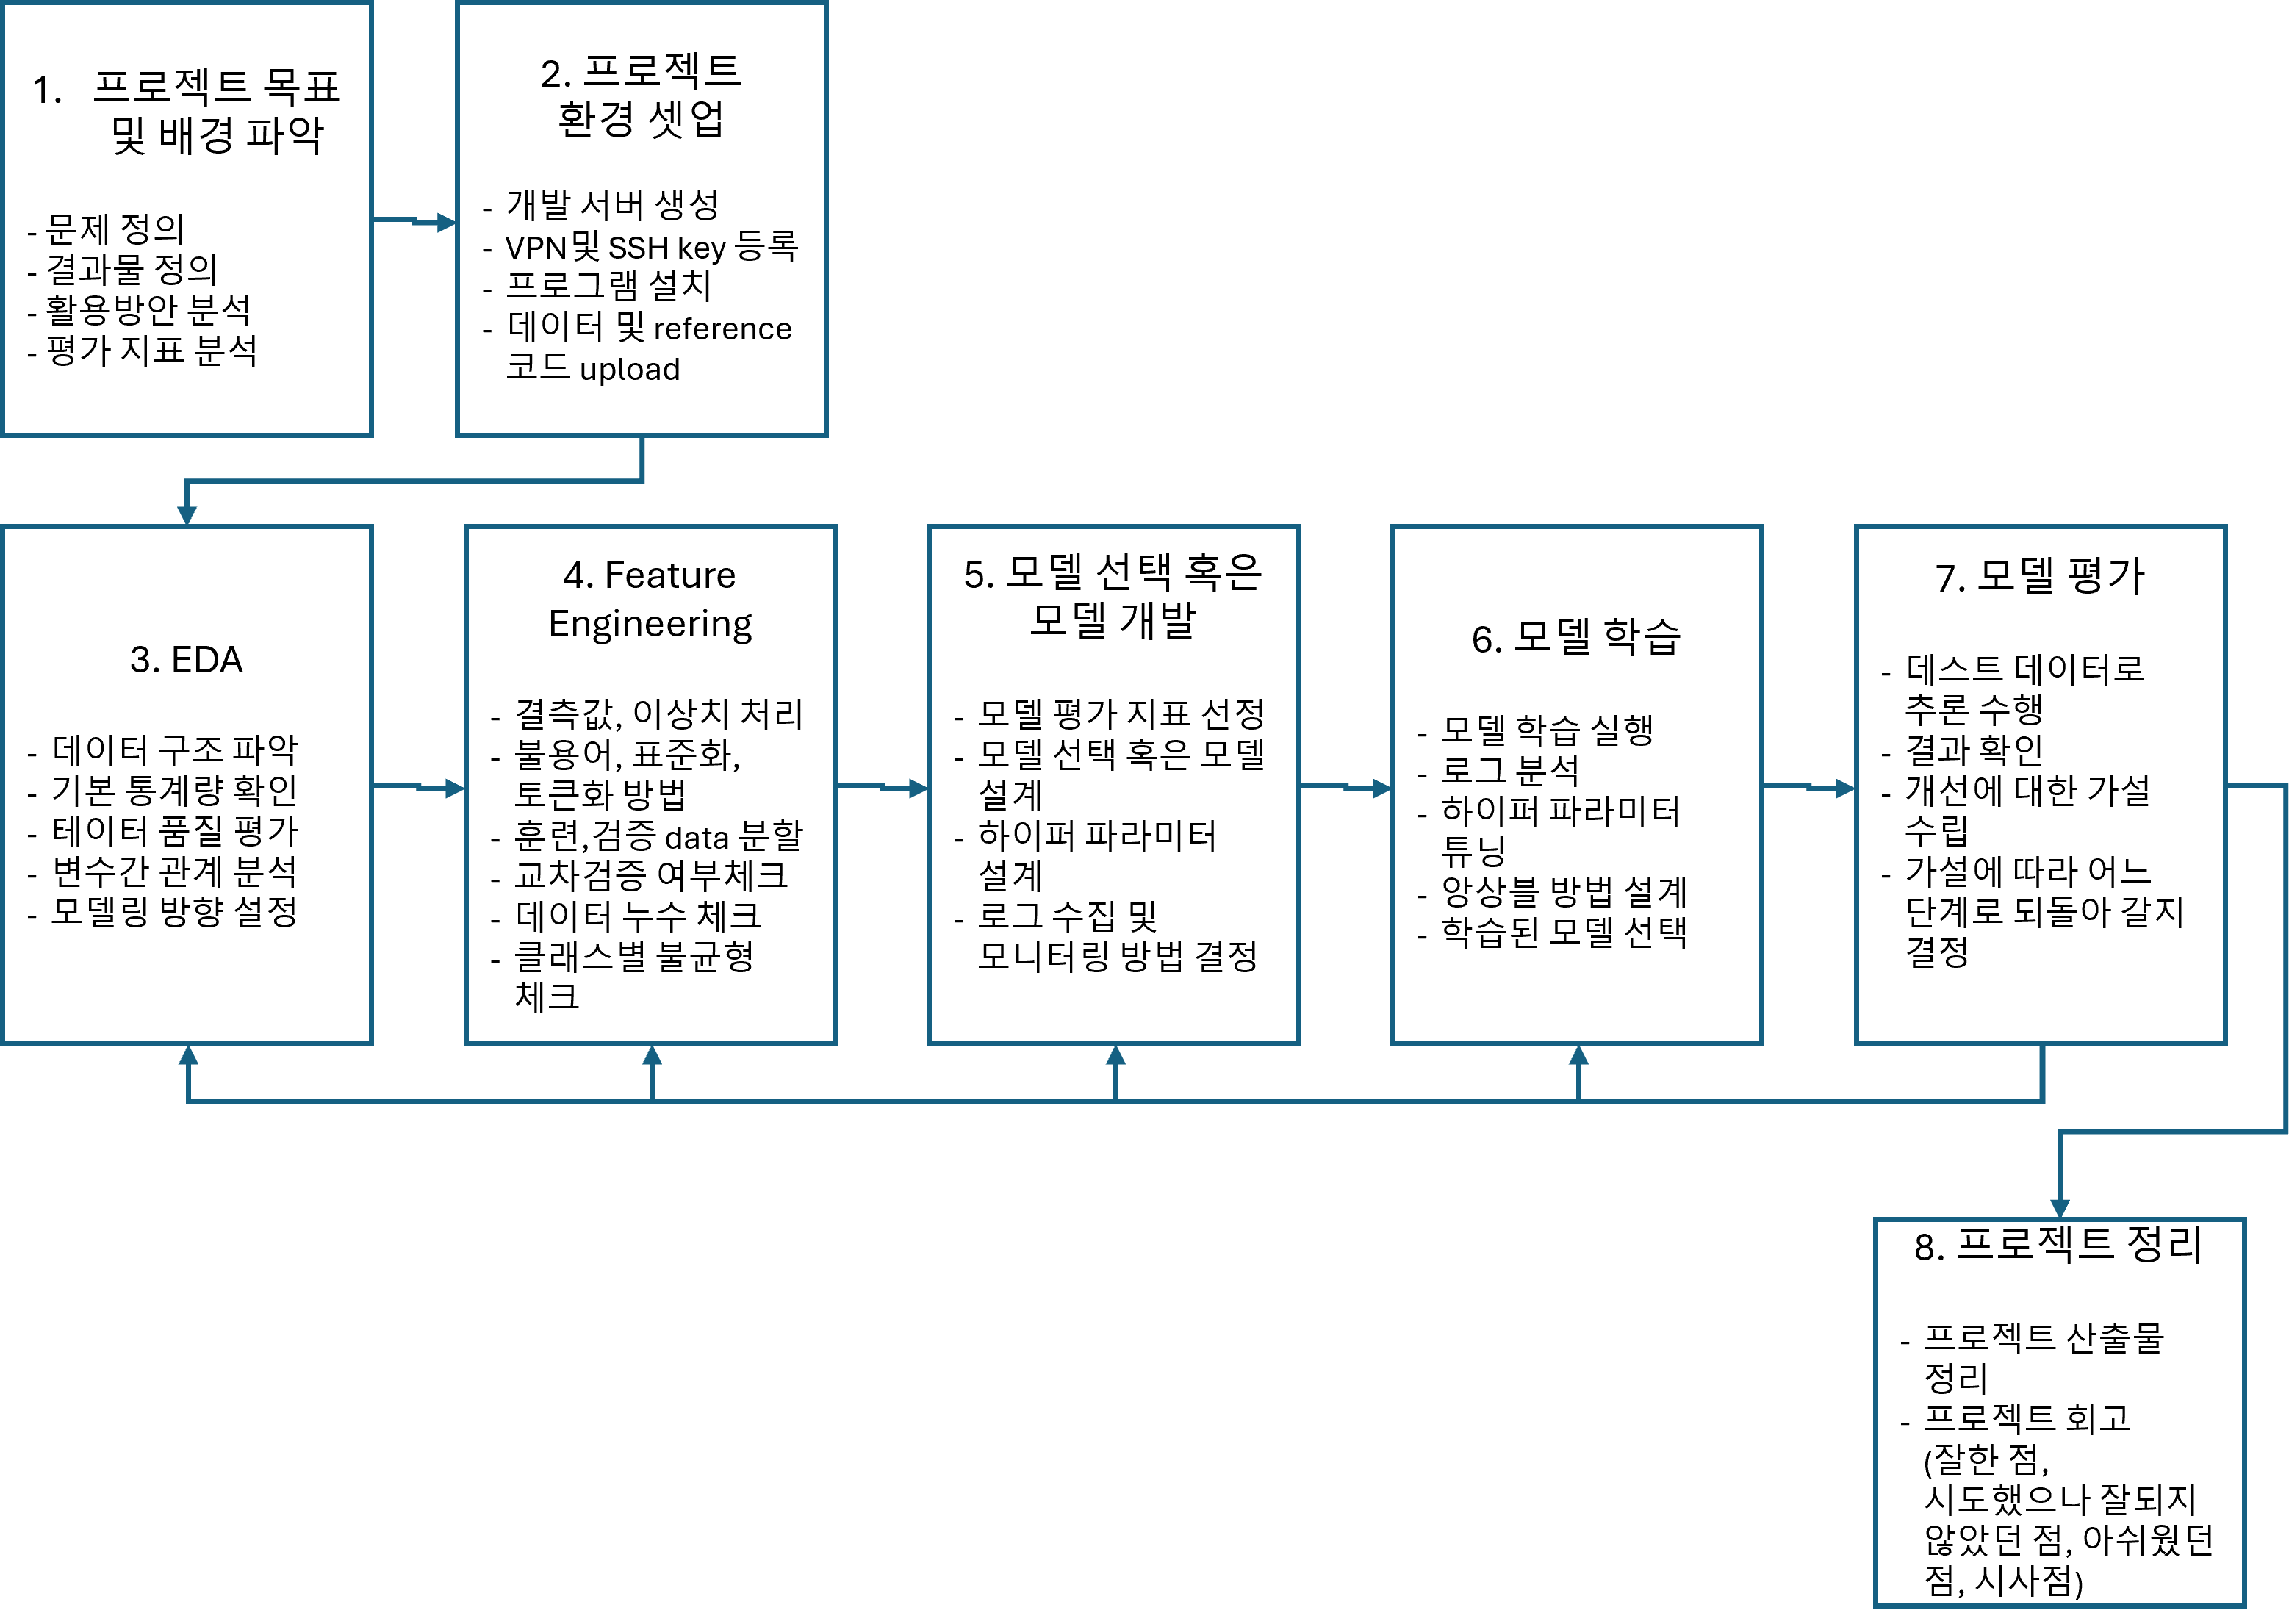

In [6]:
from IPython.display import Image
Image('./프로젝트수행절차.png', width=500)


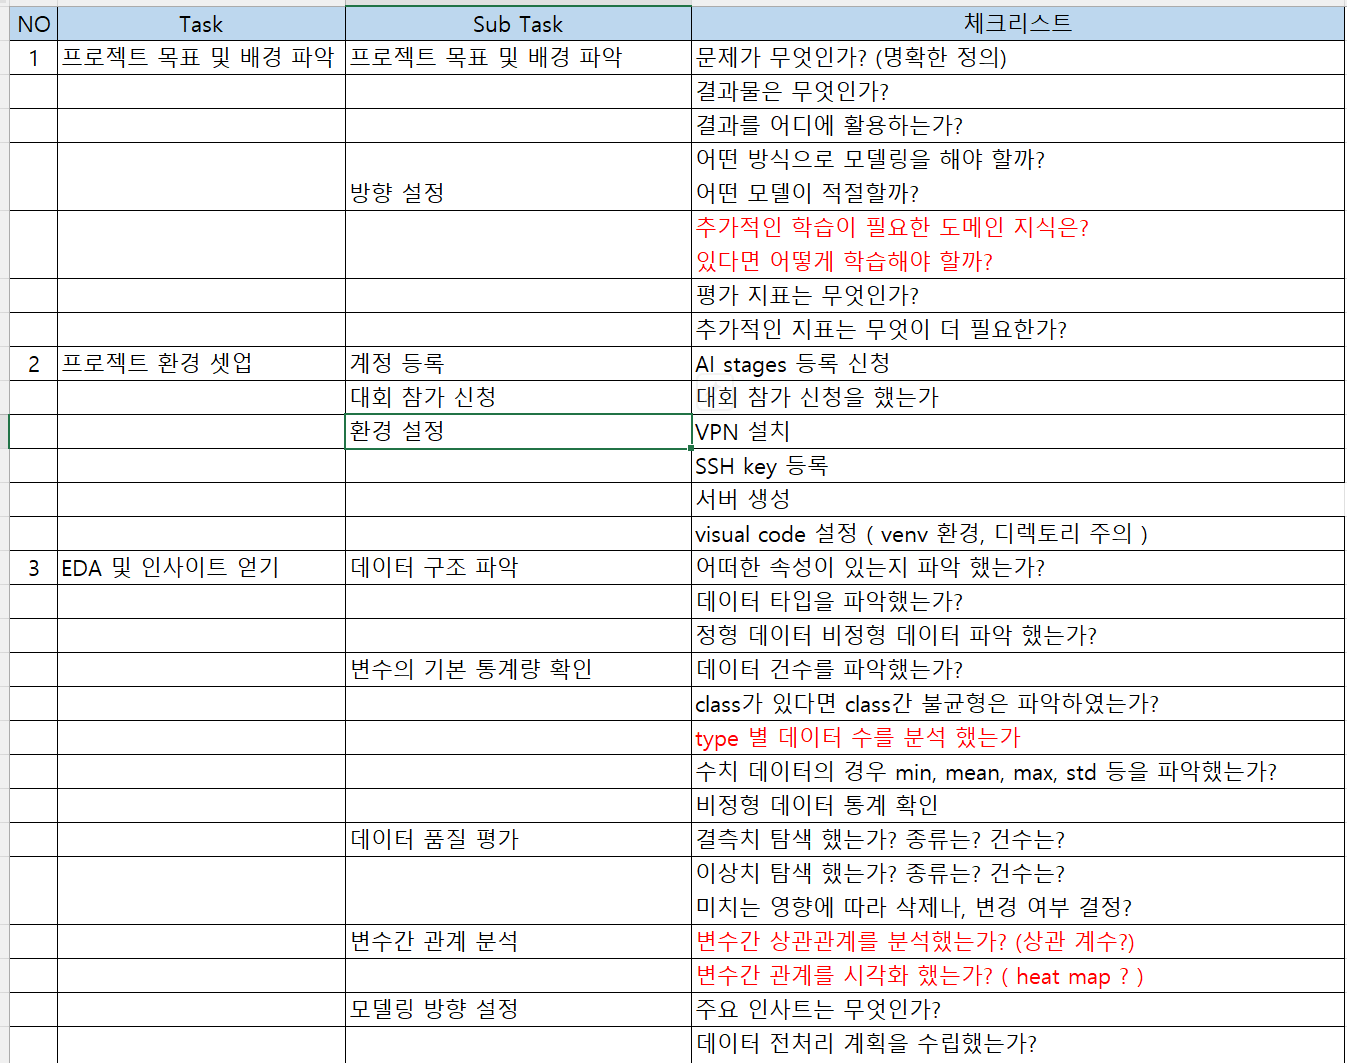

In [7]:
Image('./프로젝트진행checklist.png', width=500)

* 프로젝트 수행 방법
    * 10개의 강의와 2회의 오피스아워에서 얻은 정보를 바탕으로 프로젝트 진행 프로세스를 수립함
    * 8개의 Task로 나누고 강의와 오피스아워 시간마다 새로운 지식과 아이디어를 얻어 총 90개의 check 리스트 작성하여 프로젝트를 수행함
    * 먼저 프로세스 초안대로 진행을 하였고, 적절하지 않은 경우는 프로세스를 수정하며, “프로젝트 프로세스” <-> “실재 프로젝트 진행”이 상호 보안해 가며 진행함
    


## 3. 프로젝트 수행 결과
### EDA
* EDA로 분석 결과 class별 불균형이 심하고, augment data가 50%나 차지하고 있었음 
    * => augment data가 실 운영환경의 데이터 분포를 변화시킬 것으로 추정(data shift)
* 중복 데이터가 4000건 이상 있었고, 동일한 review의견에 대해 label 이 다른 값들이 있었음 
    * => 동일한 review에 대해 다른 label을 제시하게 되어, 일관성 없는 타겟 -> 불안정한 손실함수(loss) -> 불안정한 gradient -> 불안정한 파라미터 update -> 결과적으로 학습의 일관성이 저해됨
* Label이 고양이, 개처럼 구분되는 클래스가 아니라, 0(강한부정)~3(강한긍정)까지 연속적인 수라고 보는 것이 더 자연스러워 보임 
    * => classification문제를 regression 문제로 전환하는 아이디어를 도출함
### Feature engineering
* Class별 불균형 해소와 augment data가 너무 많은 문제를 개선하기 위해 Augment data 일부 제거: 0, 2 label 의 augment data 모두 제거 (삭제: 106,741건)
    * => (강한 부정): 32.89%, (약한 부정): 15.91%, (약한 긍정): 28.36%, (강한 긍정): 22.83% 비율로 어느정도 클래스별 밸런스를 맞춤
* 중복 데이터 제거:  삭제: 4,388건, 학습의 일관성 확보
* 텍스트 전처리, 텍스트 정규화는 baseline 코드와 동일하게 사용
* 데이터 분할
    * 하이퍼 파라미터 튜닝 과정: 학습과 검증 데이터 비율을 8:2로 나누었음
    * 최종 제출: 코드 재사용을 위한 최소 검증 데이터 4건을 제외한 모든 train 데이터로 분할함
### 모델 선택 혹은 모델 개발
* 모델 선택: 사용 가능한 다섯개 모델 학습 후 evaluation accuracy 결과를 비교하여 top 3개 모델을 선택하여 그 이후엔 데이터 전처리 방식 변경 및 하이퍼 파라미터 튜닝만 수행
    1) kykim/bert-kor-base: 0.8563,
    2) klue/roberta-base: 0.8500
    3) monologg/koelectra-base-v3-discriminator: 0.8489
    4) klue/bert-base: 0.8449,
    5) beomi/kcbert-base: 0.8407
* Ordinal regression 모델 개발(53% accuracy로 인해 개발 중단)
    * Classification 문제로 보기보다 0~3사이의 연속적인 데이터로 분포하는 회귀문제로 해결하고자 관련 아이디어로 논문을 서치함
    * 별표 점수 주기, 만족도 설문조사 등 산업현장에서 동일한 데이터가 많이 등장하고 이를 해결하고자 하는 아이디어가 이미 20년도 전에 연구가 되어 있었음. SPSS 통계 패키지에서는 이를 지원하는 기능이 있음.
    * python에서는 아직 지원하는 라이브러리가 없어서 직접 개발하기로 하고, BertForOrdinalRegression(BertPreTrainedModel) class를 구현함
구현 결과 evaluation accuracy 가 53%로 나왔고, 이틀간 개선을 시도하였나 진전이 없어서 중단함
        - BCE 기반의 변형된 loss function을 사용하였으나, 그 loss function으로 훈련했을 때 accuracy 목표 달성을 할 수 있다는 논리를 이해하지 못해 해결이 어려웠음
        - 특징을 추출하는 feature extractor layer를 classifier layer전에 추가하고 그 특징으로부터 4가지 label을 추정하는 방식을 적용하였으나 개선되지 않음
* 분포 예측 모델(아이디어)
    * 사람이 라벨링 할 때도 결정짓기 어려운 감성 판단이라 생각(ex, 0과 1사이 )
    * label 0은 N(0,1)분포로, 1은 N(1,1) 분포로, 2는 N(2,1)분포로, 3은 N(3,1)분포로 생각하고 분포(mean, var)를 예측하도록 모델을 개발
    * 분포 간의 차이인 KL Divergence를 활용한 loss function으로 학습
* VAE 아이디어를 차용한 모델(아이디어)
    * latent space로 4차원 gaussian distribution로 함
    * (review) -> (라벨+review)를 생성하는 변형된 오토인코더를 구현
    * 원점을 중심으로 하는 4차원 초공간을 4개의 영역으로 나눌 것이고 각 영역이 4개의 class에 해당하게 될 것임
### 모델 학습
* 모델 학습은 Trainer class와 wandb sweep 를 이용해 하이퍼 파라미터 튜닝과 로깅을 해결하였음
    * 처음엔 하나의 모델을 선택하여 hyper paramer를 찾았고,
    * 두번째는 동일한 하이퍼 파라미터로 모델을 비교하여 선택하였음
* Evaluation accuracy로 평가하는 것을 모델 개발 및 검증과정이라고 보았음
* Evaluation accuracy가 기존보다 낮게 나오면 그 결과는 버리고 원인을 분석하여 이전 EDA 단계 이후의 적절한 단계부터 다시 시작하였음
* Wandb sweep script를 한번 만들고 나니 모든 종류의 시험은 모두 sweep 으로 가능하다는 것을 알게 되었고, 그 후로는 모든 종류의 시험을 모두 sweep으로 처리함(어려 파라미터의 조합이 아니라 한가지 경우만 있는 시험도 sweep으로 처리)
* Layer wise learning rate 방식을 구현하여 적용하였으나, 개선점이 없어 제거함
    * Embedding layer, Encoder layer 상/하층, classifier layer등 layer별로 learning rate 를 다르게 함
    * 앞쪽에 해당할수록 적게 변경하고(혹은 freezing), classifier layer를 가장 많이 update 시킴
    
### 모델 평가
* 모델 평가는 test.csv를 추론한 결과를 제출하고 리더보드에서 확인하는 과정으로 보았음
* Test.csv 추론 과정은 앙상블 기법을 적용했는데 앙상블을 적용한 결과 모든 경우에 성능이 1% point 이상 향상되었으며, 이후 모든 실험에서 앙상블 기법을 적용함
* Bagging 기법 중 soft voting 방식을 적용하였는데, 구현하기 가장 쉬웠기 때문에 선택하였음
* 처음엔 bagging 기법이 variation을 줄여주는 효과가 있다고 강의 때 배워서 accuracy 높이는데는 효과가 없을 것이라 짐작하고 구현 계획에 없었으나, 팀원들 중 먼저 경험한 사람들의 성공담을 듣고 시도함
* 앙상블은 프로젝트 기간 중에 시도한 feature engineering, 모델 변경, 하이퍼 파라미터 튜닝의 모든 시도보다 월등한 성과가 있었음



## 4. 자체 평가 의견 및 회고
### 잘한 점들
* 프로젝트 진행하면서 필요한 task와 check list를 작성
* Wandb를 통한 로그 모니터링 환경 구축 경험
* 앙상블을 시도한 점
* 소스 구조 정리
* Task 및 체크리스트와 소스 구조는 향후 프로젝트에서 참조할 예정임
* 소스 구조
```txt
    .
    |-- data
    |   |-- output
    |   |   |-- output_v.01.csv
    |   |   `-- output_v.02.csv
    |   |-- processed
    |   `-- raw
    |       |-- sample_submission.csv
    |       |-- small.csv
    |       |-- test.csv
    |       `-- train.csv
    |-- docs
    |-- logs
    |   `-- moodlazer_20251030.log
    |-- models
    |   |-- best_model
    |   `-- best_model_keep
    |       |-- bert
    |       |-- electra
    |       `-- roberta4
    |-- pyproject.toml
    |-- scripts
    |   |-- EDA_and_preprocession.ipynb
    |   |-- ex_config.py
    |   |-- ex_data_loader.py
    |   |-- ex_logger.py
    |   |-- predict.py
    |   |-- sweep.py
    |   `-- train.py
    |-- src
    |   `-- moodlazer
    |       |-- __init__.py
    |       |-- config.py
    |       |-- data_loader.py
    |       |-- logger.py
    |       |-- model.py
    |       |-- train.py
    |       `-- utils.py
    |-- tests
    |   |-- test_config.py
    |   |-- test_data_loader.py
    |   `-- test_logger.py
    `-- wandb

```


### 시도했으나 잘 되지 않았던 점들
* Ordinal regression 모델을 구현하여 학습했으나, accuracy 가 50%대로 나와 실패
### 아쉬웠던 점들
* 분포 예측 모델, VAE 변형 모델 등 해보고 싶은 아이디어는 많았는데, 시간내에 다 해볼 수 있는 능력이 아직 부족해서 못해 봄
* CLS token 대신 mean pooling 기법을 적용해 보고 싶었으나 구현하지 못함
* Layer wise learning rate를 좀더 다양하게 변경해 가며 하면 효과가 있을 것 같다는 느낌은 있었으나, 시간내 적절한 수치를 찾지 못함
### 프로젝트를 통해 배운 점 또는 시사점
* 앙상블의 효과를 체험함
* 새로운 아이디어가 있다면, 누군가가 이미 고민했을 수 있으니, 관련 논문을 찾아보는 것이 좋음
* Ordinal regression을 시도하면서 Loss function의 역할과 중요성을 알게 됨
    * loss function은 gradient descent 방식의 학습에 필수적일 뿐만 아니라, 학습의 효율을 좌우하는 중요한 요소임.
    * 손실함수가 적절하지 않으면 학습 데이터가 아무리 많아도 목표 달성 불가능하며, epoch을 아무리 많이 반복해도 목표달성 불가능
* 소스 디렉토리 구조를 고민하고 정리함